# Introduce
### Project goal
The project will aim to build a robust generative search system capable of effectively and accurately answering questions from a policy document.

### Data source
I use a single long-life insurance policy document for this project. The PDF for the document can be downloaded at [link_to_download](https://drive.google.com/file/d/1_SJjkgTLO0xPJx8bfoRZoSMx9xVw9o0L/view?usp=sharing)

### Design choices
![image.png](image/image.png)
I implement step by step:
- Embedding Layer
- Search Layer 
- Generative Layer
- Query Search
- Compare the retrieval result from 2 methods: cross_encoder and bi_encoder

### Challenges faced
Most of the challenges are from the parameter selection. It is tough to find the chunking size, and top k retrieval documents.

When we have a lot of retrieved documents, the LLM can not find the important information to generate a good answer, besides we have a limitation of input and output tokens.

While we had fewer retrieved documents, we did not have enough pieces of information to generate the answer.


# Import the Required Libraries

In [1]:
# Import all the required Libraries

import pdfplumber
import pandas as pd
from operator import itemgetter
import json
import openai
import chromadb
from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction
from langchain_text_splitters import RecursiveCharacterTextSplitter, CharacterTextSplitter
from langchain.schema import Document
from sentence_transformers import CrossEncoder
import random
from sentence_transformers import SentenceTransformer
import numpy as np


/Users/cuong/anaconda3/envs/rag_helpmate/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


# Embedding layer - Indexing






## Extract content from pdf
return full_text => list[[page, content]]

In [2]:
def check_bboxes(word, table_bbox):
    # check whether word is inside a table bbox
    l = word['x0'], word['top'], word['x1'], word['bottom']
    r = table_bbox
    return l[0] > r[0] and l[1] > r[1] and l[2] < r[2] and l[3] < r[3]
def extract_text_from_pdf(pdf_path):
    p = 0
    full_text = []


    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            page_no = f"Page {p+1}"

            tables = page.find_tables()
            table_bboxes = [i.bbox for i in tables]
            tables = [{'table': i.extract(), 'top': i.bbox[1]} for i in tables]
            non_table_words = [word for word in page.extract_words() if not any(
                [check_bboxes(word, table_bbox) for table_bbox in table_bboxes])]
            lines = []

            for cluster in pdfplumber.utils.cluster_objects(non_table_words + tables, itemgetter('top'), tolerance=5):

                if 'text' in cluster[0]:
                    try:
                        lines.append(' '.join([i['text'] for i in cluster]))
                    except KeyError:
                        pass

                elif 'table' in cluster[0]:
                    lines.append(json.dumps(cluster[0]['table']))


            full_text.append([page_no, " ".join(lines)])
            p +=1

    return full_text

In [3]:
pdf_path = "Principal-Sample-Life-Insurance-Policy.pdf"
extracted_text = extract_text_from_pdf(pdf_path)
pdfs_data = pd.DataFrame(extracted_text, columns=['Page No.', 'Page_Text'])
pdfs_data['Document Name'] = pdf_path.split("/")[-1]

pdfs_data.head()

,Page No.,Page_Text,Document Name
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,Principal-Sample-Life-Insurance-Policy.pdf
1,Page 2,This page left blank intentionally,Principal-Sample-Life-Insurance-Policy.pdf
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,Principal-Sample-Life-Insurance-Policy.pdf
3,Page 4,This page left blank intentionally,Principal-Sample-Life-Insurance-Policy.pdf
4,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,Principal-Sample-Life-Insurance-Policy.pdf


In [4]:
pdfs_data['Text_Length'] = pdfs_data['Page_Text'].apply(lambda x: len(x.split(' ')))
pdfs_data.head()

,Page No.,Page_Text,Document Name,Text_Length
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,Principal-Sample-Life-Insurance-Policy.pdf,30
1,Page 2,This page left blank intentionally,Principal-Sample-Life-Insurance-Policy.pdf,5
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,Principal-Sample-Life-Insurance-Policy.pdf,230
3,Page 4,This page left blank intentionally,Principal-Sample-Life-Insurance-Policy.pdf,5
4,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,Principal-Sample-Life-Insurance-Policy.pdf,110


## EDA and preprocessing

Text(0, 0.5, 'Frequency')

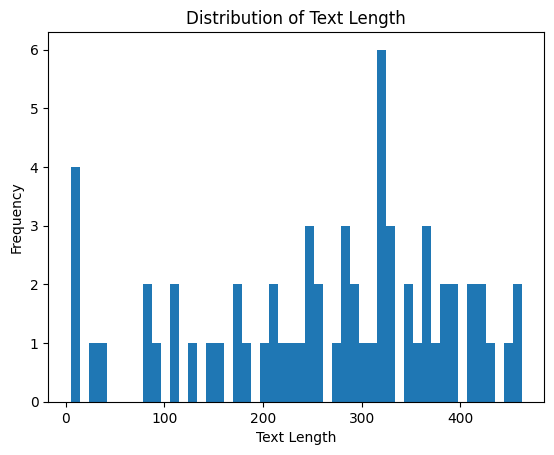

In [5]:
## Plot dist of text_length
ax = pdfs_data['Text_Length'].plot(kind='hist', bins=50, title='Distribution of Text Length')
ax.set_xlabel('Text Length')
ax.set_ylabel('Frequency')

In [6]:
# Retain only the rows with a text length of at least 10

pdfs_data = pdfs_data.loc[pdfs_data['Text_Length'] >= 10]
pdfs_data.head()

,Page No.,Page_Text,Document Name,Text_Length
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,Principal-Sample-Life-Insurance-Policy.pdf,30
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,Principal-Sample-Life-Insurance-Policy.pdf,230
4,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,Principal-Sample-Life-Insurance-Policy.pdf,110
5,Page 6,TABLE OF CONTENTS PART I - DEFINITIONS PART II...,Principal-Sample-Life-Insurance-Policy.pdf,153
6,Page 7,Section A – Eligibility Member Life Insurance ...,Principal-Sample-Life-Insurance-Policy.pdf,176


## Create metadata

In [7]:
# Store the metadata for each page in a separate column

pdfs_data['Metadata'] = pdfs_data.apply(lambda x: {'Policy_Name': x['Document Name'][:-4], 'Page_No.': x['Page No.']}, axis=1)
pdfs_data.head()

,Page No.,Page_Text,Document Name,Text_Length,Metadata
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,Principal-Sample-Life-Insurance-Policy.pdf,30,{'Policy_Name': 'Principal-Sample-Life-Insuran...
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,Principal-Sample-Life-Insurance-Policy.pdf,230,{'Policy_Name': 'Principal-Sample-Life-Insuran...
4,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,Principal-Sample-Life-Insurance-Policy.pdf,110,{'Policy_Name': 'Principal-Sample-Life-Insuran...
5,Page 6,TABLE OF CONTENTS PART I - DEFINITIONS PART II...,Principal-Sample-Life-Insurance-Policy.pdf,153,{'Policy_Name': 'Principal-Sample-Life-Insuran...
6,Page 7,Section A – Eligibility Member Life Insurance ...,Principal-Sample-Life-Insurance-Policy.pdf,176,{'Policy_Name': 'Principal-Sample-Life-Insuran...


## Chunking and Embedding

In [8]:
# Set the API key
from dotenv import load_dotenv
load_dotenv("../.env")
import os
openai.api_key = os.environ.get("OPENAI_API_KEY")

In [9]:
# Define the path where chroma collections will be stored

chroma_data_path = '../ChromaDB'
# Call PersistentClient()

client = chromadb.PersistentClient(chroma_data_path)

In [10]:
# Define chunking method
def chunking(method: str):
    """return TextSplitter with one chunking method"""
    if method == 'RecursiveCharacterTextSplitter':
        return RecursiveCharacterTextSplitter(
            # Set a really small chunk size, just to show.
            chunk_size=1000,
            chunk_overlap=200,
            length_function=len,
        )
    elif method == 'CharacterTextSplitter':
        return CharacterTextSplitter(
            separator=" ",
            chunk_size=1000,
            chunk_overlap=200,
            length_function=len,
            is_separator_regex=False,
        )
    else:
        raise ValueError(f"Unknown chunking method: {method}")

In [11]:
# Set up the embedding function using the OpenAI embedding model
model = "text-embedding-ada-002"
embedding_function = OpenAIEmbeddingFunction(api_key=openai.api_key, model_name=model)
# Initialise a collection in chroma and pass the embedding_function to it so that it used OpenAI embeddings to embed the documents
collection = client.get_or_create_collection(name='RAG_HELPMATE', embedding_function=embedding_function)
# Initialise a chunking method
text_splitter = chunking(method='RecursiveCharacterTextSplitter')

In [12]:
# Convert the page text and metadata from your dataframe to lists to be able to pass it to chroma
documents_list = pdfs_data["Page_Text"].tolist()
metadata_list = pdfs_data['Metadata'].tolist()

In [13]:
documents = text_splitter.create_documents(
    documents_list, metadatas=metadata_list
)
documents[0]

Document(metadata={'Policy_Name': 'Principal-Sample-Life-Insurance-Policy', 'Page_No.': 'Page 1'}, page_content='DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/01/2014 711 HIGH STREET GEORGE RI 02903 GROUP POLICY FOR: RHODE ISLAND JOHN DOE ALL MEMBERS Group Member Life Insurance Print Date: 07/16/2014')

In [14]:
print(len(documents))
print(len(documents_list))

141
60


In [15]:
split_document_list = [doc.page_content for doc in documents]
split_metadata_list = [doc.metadata for doc in documents]


In [16]:
# Add the documents and metadata to the collection alongwith generic integer IDs. You can also feed the metadata information as IDs by combining the policy name and page no.
collection.add(
    documents= split_document_list,
    ids = [str(i) for i in range(0, len(split_document_list))],
    metadatas = split_metadata_list
)

# Searching layer

## caching

In [17]:
# Implementing Cache in Semantic Search
class Caching():
  def __init__(self, collection):
    self.collection = collection
    self.cache_collection = client.get_or_create_collection(name='Cache', embedding_function=embedding_function)
    self.threshold = 0.2
    self.ids = []
    self.documents = []
    self.distances = []
    self.metadatas = []


  def search(self, query):
    cache_results = self.cache_collection.query(
        query_texts=query,
        n_results=1
    )
    # If the distance is greater than the threshold, then return the results from the main collection.
    if cache_results['distances'][0] == [] or cache_results['distances'][0][0] > self.threshold:
          # Query the collection against the user query and return the top 10 results
          results = self.collection.query(
          query_texts=query,
          n_results=10
          )

          # Store the query in cache_collection as document w.r.t to ChromaDB so that it can be embedded and searched against later
          # Store retrieved text, ids, distances and metadatas in cache_collection as metadatas, so that they can be fetched easily if a query indeed matches to a query in cache
          Keys = []
          Values = []

          for key, val in results.items():
            if val is None:
              continue
            for i in range(10):
              try:
                Keys.append(str(key)+str(i))
                Values.append(str(val[0][i]))
              except:
                 pass


          self.cache_collection.add(
              documents= [query],
              ids = [query], #[len(cache_results['documents'])],   # Or if you want to assign integers as IDs 0,1,2,.., then you can use "len(cache_results['documents'])" as will return the no. of queries currently in the cache and assign the next digit to the new query."
              metadatas = dict(zip(Keys, Values))
          )

          print("Not found in cache. Found in main collection.")

          result_dict = {'Metadatas': results['metadatas'][0], 'Documents': results['documents'][0], 'Distances': results['distances'][0], "IDs":results["ids"][0]}
          results_df = pd.DataFrame.from_dict(result_dict)


    # If the distance is, however, less than the threshold, you can return the results from cache

    elif cache_results['distances'][0][0] <= self.threshold:
          cache_result_dict = cache_results['metadatas'][0][0]

          # Loop through each inner list and then through the dictionary
          for key, value in cache_result_dict.items():
              if 'ids' in key:
                  self.ids.append(value)
              elif 'documents' in key:
                  self.documents.append(value)
              elif 'distances' in key:
                  self.distances.append(value)
              elif 'metadatas' in key:
                  self.metadatas.append(value)

          print("Found in cache!")

          # Create a DataFrame
          results_df = pd.DataFrame({
            'IDs': self.ids,
            'Documents': self.documents,
            'Distances': self.distances,
            'Metadatas': self.metadatas
          })
    return results_df


In [18]:
# Initial the caching
cache = Caching(collection)

In [19]:
results_df = cache.search("What is the print date?")
results_df

Not found in cache. Found in main collection.


,Metadatas,Documents,Distances,IDs
0,"{'Page_No.': 'Page 20', 'Policy_Name': 'Princi...",then been in force 24 months or more and if Wr...,0.488860,36
1,"{'Page_No.': 'Page 31', 'Policy_Name': 'Princi...",date Proof of Good Health is approved by The P...,0.495518,60
2,"{'Page_No.': 'Page 31', 'Policy_Name': 'Princi...",Member for which Proof of Good Health is requi...,0.513355,61
3,"{'Page_No.': 'Page 21', 'Policy_Name': 'Princi...",the volume of insurance for then insured Membe...,0.521031,38
4,"{'Page_No.': 'Page 21', 'Policy_Name': 'Princi...",b . on any date the definition of Member or De...,0.525150,37
5,"{'Page_No.': 'Page 30', 'Policy_Name': 'Princi...",Scheduled Benefit amount because of a change i...,0.528517,58
6,"{'Page_No.': 'Page 62', 'Policy_Name': 'Princi...",may be started later than three years after th...,0.529761,140
7,"{'Page_No.': 'Page 28', 'Policy_Name': 'Princi...",under this Group Policy replaces coverage unde...,0.541384,52
8,"{'Page_No.': 'Page 18', 'Policy_Name': 'Princi...",c . a copy of the form which contains the stat...,0.542952,31
9,"{'Page_No.': 'Page 42', 'Policy_Name': 'Princi...",Disability . c. Application/Effective Date Not...,0.543616,88


In [22]:
results_df = cache.search("when is the print date?")
results_df

Found in cache!


,IDs,Documents,Distances,Metadatas
0,25,A record which is on or transmitted by paper o...,0.4523160755634308,"{'Page_No.': 'Page 15', 'Policy_Name': 'Princi..."
1,36,then been in force 24 months or more and if Wr...,0.48858171701431274,"{'Page_No.': 'Page 20', 'Policy_Name': 'Princi..."
2,60,date Proof of Good Health is approved by The P...,0.49551770091056824,"{'Page_No.': 'Page 31', 'Policy_Name': 'Princi..."
3,61,Member for which Proof of Good Health is requi...,0.5133541226387024,"{'Page_No.': 'Page 31', 'Policy_Name': 'Princi..."
4,38,the volume of insurance for then insured Membe...,0.5210309624671936,"{'Page_No.': 'Page 21', 'Policy_Name': 'Princi..."
5,37,b . on any date the definition of Member or De...,0.5250705480575562,"{'Page_No.': 'Page 21', 'Policy_Name': 'Princi..."
6,58,Scheduled Benefit amount because of a change i...,0.5270731449127197,"{'Page_No.': 'Page 30', 'Policy_Name': 'Princi..."
7,140,may be started later than three years after th...,0.5297504386368884,"{'Page_No.': 'Page 62', 'Policy_Name': 'Princi..."
8,52,under this Group Policy replaces coverage unde...,0.5413839817047119,"{'Page_No.': 'Page 28', 'Policy_Name': 'Princi..."
9,31,c . a copy of the form which contains the stat...,0.5428417325019836,"{'Page_No.': 'Page 18', 'Policy_Name': 'Princi..."


## Re-ranker
- I use cross-encoder/ms-marco-MiniLM-L-6-v2 for cross_encoder and bi_encoder to compare the result from 2 methods

### Use CrossEncoder

In [20]:
cross_encoder = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-6-v2")

/Users/cuong/anaconda3/envs/rag_helpmate/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [21]:
# Test the cross encoder model

scores = cross_encoder.predict([['Does the insurance cover diabetic patients?', 'The insurance policy covers some pre-existing conditions including diabetes, heart diseases, etc. The policy does not howev'],
                                ['Does the insurance cover diabetic patients?', 'The premium rates for various age groups are given as follows. Age group (<18 years): Premium rate']])
scores

array([  3.8467636, -11.25288  ], dtype=float32)

### Use Bi-Encoder

In [22]:
# load model
# model = SentenceTransformer("all-MiniLM-L6-v2")
model = SentenceTransformer("cross-encoder/ms-marco-MiniLM-L-6-v2")

sen1 = "Does the insurance cover diabetic patients?"
sen2 = "The insurance policy covers some pre-existing conditions including diabetes, heart diseases, etc. The policy does not howev"
em_sen1 = model.encode(sen1)
em_sen2 = model.encode(sen2)
score = model.similarity(em_sen1, [em_sen2,em_sen2])
np.array(score)[0]

No sentence-transformers model found with name cross-encoder/ms-marco-MiniLM-L-6-v2. Creating a new one with mean pooling.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/Users/cuong/anaconda3/envs/rag_helpmate/lib/python3.10/site-packages/sentence_transformers/util.py:33: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)
  a = torch.tensor(a)


array([0.9598117, 0.9598117], dtype=float32)

### Implement 

In [23]:
# Implementing Cache with re-ranker in Semantic Search
class Caching():
  def __init__(self, collection):
    self.collection = collection
    self.cache_collection = client.get_or_create_collection(name='Cache', embedding_function=embedding_function)
    self.threshold = 0.2
    self.model_bi_encoder = SentenceTransformer("cross-encoder/ms-marco-MiniLM-L-6-v2")
    self.cross_encoder = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-6-v2")

  def bi_encoder(self, query, bi_input):
    em_query = model.encode(query)
    em_input = [model.encode(sen) for sen in bi_input]
    scores = model.similarity(em_query, em_input) 
    return np.array(scores)[0]
  
  def re_rank(self,rerank_method, query, results_df, top_k=-1): 
    # set return top reranked documents   
    # when top_k = -1, we just resort the searched output
    if top_k == -1 or top_k > len(results_df) :
       top_k = len(results_df)
    # rerank the result
    if rerank_method == "cross_encoder":
       cross_inputs  =  [[query, response] for response in results_df['Documents']]
       rerank_scores = self.cross_encoder.predict(cross_inputs)
    elif rerank_method == "bi_encoder":
       bi_input = [res for res in results_df["Documents"]]
       rerank_scores = self.bi_encoder(query, bi_input)
    else:
       rerank_scores = [0 for i in results_df['Documents']]
    results_df['Reranked_scores'] = rerank_scores
    results_df = results_df.sort_values(by="Reranked_scores", ascending=False)
    return results_df[:top_k]
       
  def search(self, query, top_k=4,rerank_method="cross_encoder"):
    # initial variables
    ids = []
    documents = []
    distances = []
    metadatas = []
    cache_results = self.cache_collection.query(
        query_texts=query,
        n_results=1
    )
    # If the distance is greater than the threshold, then return the results from the main collection.
    if cache_results['distances'][0] == [] or cache_results['distances'][0][0] > self.threshold:
          # Query the collection against the user query and return the top 10 results
          results = self.collection.query(
          query_texts=query,
          n_results=10
          )

          # Store the query in cache_collection as document w.r.t to ChromaDB so that it can be embedded and searched against later
          # Store retrieved text, ids, distances and metadatas in cache_collection as metadatas, so that they can be fetched easily if a query indeed matches to a query in cache
          Keys = []
          Values = []

          for key, val in results.items():
            if val is None:
              continue
            for i in range(10):
              try:
                Keys.append(str(key)+str(i))
                Values.append(str(val[0][i]))
              except:
                 pass


          self.cache_collection.add(
              documents= [query],
              ids = [query], #[len(cache_results['documents'])],   # Or if you want to assign integers as IDs 0,1,2,.., then you can use "len(cache_results['documents'])" as will return the no. of queries currently in the cache and assign the next digit to the new query."
              metadatas = dict(zip(Keys, Values))
          )

          print("Not found in cache. Found in main collection.")

          result_dict = {'Metadatas': results['metadatas'][0], 'Documents': results['documents'][0], 'Distances': results['distances'][0], "IDs":results["ids"][0]}
          results_df = pd.DataFrame.from_dict(result_dict)


    # If the distance is, however, less than the threshold, you can return the results from cache

    elif cache_results['distances'][0][0] <= self.threshold:
          cache_result_dict = cache_results['metadatas'][0][0]

          # Loop through each inner list and then through the dictionary
          for key, value in cache_result_dict.items():
              if 'ids' in key:
                  ids.append(value)
              elif 'documents' in key:
                  documents.append(value)
              elif 'distances' in key:
                  distances.append(value)
              elif 'metadatas' in key:
                  metadatas.append(value)

          print("Found in cache!")

          # Create a DataFrame
          results_df = pd.DataFrame({
            'IDs': ids,
            'Documents': documents,
            'Distances': distances,
            'Metadatas': metadatas
          })
    # re rank the result 
    results_df = self.re_rank(rerank_method, query, results_df, top_k=top_k)

    return results_df


In [24]:
# Initial the caching
cache = Caching(collection, )

# the result with cross_encoder method
results_df = cache.search("when is the print date?", rerank_method="cross_encoder", top_k=-1)
results_df

No sentence-transformers model found with name cross-encoder/ms-marco-MiniLM-L-6-v2. Creating a new one with mean pooling.


Found in cache!


,IDs,Documents,Distances,Metadatas,Reranked_scores
0,36,then been in force 24 months or more and if Wr...,0.4888600707054138,"{'Page_No.': 'Page 20', 'Policy_Name': 'Princi...",-7.861535
9,88,Disability . c. Application/Effective Date Not...,0.5436161756515503,"{'Page_No.': 'Page 42', 'Policy_Name': 'Princi...",-8.962295
3,38,the volume of insurance for then insured Membe...,0.5210309624671936,"{'Page_No.': 'Page 21', 'Policy_Name': 'Princi...",-9.197831
2,61,Member for which Proof of Good Health is requi...,0.5133545398712158,"{'Page_No.': 'Page 31', 'Policy_Name': 'Princi...",-9.915037
4,37,b . on any date the definition of Member or De...,0.5251502990722656,"{'Page_No.': 'Page 21', 'Policy_Name': 'Princi...",-9.931110
1,60,date Proof of Good Health is approved by The P...,0.49551770091056824,"{'Page_No.': 'Page 31', 'Policy_Name': 'Princi...",-10.175892
5,58,Scheduled Benefit amount because of a change i...,0.5285170078277588,"{'Page_No.': 'Page 30', 'Policy_Name': 'Princi...",-10.418126
7,52,under this Group Policy replaces coverage unde...,0.5413839817047119,"{'Page_No.': 'Page 28', 'Policy_Name': 'Princi...",-10.753594
6,140,may be started later than three years after th...,0.5297607732932328,"{'Page_No.': 'Page 62', 'Policy_Name': 'Princi...",-10.809189
8,31,c . a copy of the form which contains the stat...,0.5429515242576599,"{'Page_No.': 'Page 18', 'Policy_Name': 'Princi...",-11.288203


In [25]:
# the result with bi_encoder method

results_df = cache.search("when is the print date?", rerank_method="bi_encoder", top_k=-1)
results_df

Found in cache!


,IDs,Documents,Distances,Metadatas,Reranked_scores
6,140,may be started later than three years after th...,0.5297607732932328,"{'Page_No.': 'Page 62', 'Policy_Name': 'Princi...",0.853585
0,36,then been in force 24 months or more and if Wr...,0.4888600707054138,"{'Page_No.': 'Page 20', 'Policy_Name': 'Princi...",0.840227
7,52,under this Group Policy replaces coverage unde...,0.5413839817047119,"{'Page_No.': 'Page 28', 'Policy_Name': 'Princi...",0.781096
8,31,c . a copy of the form which contains the stat...,0.5429515242576599,"{'Page_No.': 'Page 18', 'Policy_Name': 'Princi...",0.637631
4,37,b . on any date the definition of Member or De...,0.5251502990722656,"{'Page_No.': 'Page 21', 'Policy_Name': 'Princi...",0.593535
2,61,Member for which Proof of Good Health is requi...,0.5133545398712158,"{'Page_No.': 'Page 31', 'Policy_Name': 'Princi...",0.549570
3,38,the volume of insurance for then insured Membe...,0.5210309624671936,"{'Page_No.': 'Page 21', 'Policy_Name': 'Princi...",0.511111
9,88,Disability . c. Application/Effective Date Not...,0.5436161756515503,"{'Page_No.': 'Page 42', 'Policy_Name': 'Princi...",0.501001
5,58,Scheduled Benefit amount because of a change i...,0.5285170078277588,"{'Page_No.': 'Page 30', 'Policy_Name': 'Princi...",0.480931
1,60,date Proof of Good Health is approved by The P...,0.49551770091056824,"{'Page_No.': 'Page 31', 'Policy_Name': 'Princi...",0.334433


# Generative Layer

In [26]:
def generate_response(cache, query, rerank_method= 'cross_encoder'):
    results_df = cache.search(query, rerank_method = rerank_method, top_k=3)
    """ 
        Generate a response using GPT-3.5's ChatCompletion based on the user query and retrieved information.
    """
    messages = [
                {"role": "system", "content":  "You are a helpful assistant in the insurance domain who can effectively answer user queries about insurance policies and documents."},
                {"role": "user", "content": f"""You are a helpful assistant in the insurance domain who can effectively answer user queries about insurance policies and documents.
                                                You have a question asked by the user in '{query}' and you have some search results from a corpus of insurance documents in the dataframe '{results_df}'. These search results are essentially one page of an insurance document that may be relevant to the user query.

                                                The column 'documents' inside this dataframe contains the actual text from the policy document and the column 'metadata' contains the policy name and source page. The text inside the document may also contain tables in the format of a list of lists where each of the nested lists indicates a row.

                                                Use the documents in '{results_df}' to answer the query '{query}'. Frame an informative answer and also, use the dataframe to return the relevant policy names and page numbers as citations.

                                                Follow the guidelines below when performing the task.
                                                1. Try to provide relevant/accurate numbers if available.
                                                2. You don’t have to necessarily use all the information in the dataframe. Only choose information that is relevant.
                                                3. If the document text has tables with relevant information, please reformat the table and return the final information in a tabular in format.
                                                3. Use the Metadatas columns in the dataframe to retrieve and cite the policy name(s) and page numbers(s) as citation.
                                                4. If you can't provide the complete answer, please also provide any information that will help the user to search specific sections in the relevant cited documents.
                                                5. You are a customer facing assistant, so do not provide any information on internal workings, just answer the query directly.

                                                The generated response should answer the query directly addressing the user and avoiding additional information. If you think that the query is not relevant to the document, reply that the query is irrelevant. Provide the final response as a well-formatted and easily readable text along with the citation. Provide your complete response first with all information, and then provide the citations.
                                                """},
              ]
    response = openai.chat.completions.create(
        model = 'gpt-3.5-turbo',
        messages= messages
    )
    return response.choices[0].message.content



In [27]:
query = "What is the printed date of life policy"
answer = generate_response(cache,  query, rerank_method= 'cross_encoder')
print(answer)

Not found in cache. Found in main collection.
The printed date of the life policy is not available in the provided document snippets. I recommend checking the specific sections related to policy details, policy issuance, or policy document overview within the mentioned policy documents to find the printed date information.

Citations:
1. Policy Name: Principal Life Insurance Policy
   Page Number: Page 26

2. Policy Name: Principal Life Insurance Policy
   Page Number: Page 21

3. Policy Name: Principal Life Insurance Company Policy
   Page Number: Page 5


# Query Search


## Generate the question
 1. Random 1 document from collection and based on this to generate the question
 2. Ask a "noise" question which is not in the document
>Then I have 4 questions:
- question1: 'Can you please explain the criteria for a member to be considered Terminally Ill for Accelerated Benefits?'

From provided document: and operating policies developed and monitored by a professional group that includes at least one M
D
 or D
O
; and c
 has an existing contract for the services of an M
D
 or D
O
, maintains daily records on each patient, and is equipped to dispense and administer drugs; and d
 provides 24-hour nursing care and other medical treatment
 Not included are rest homes, homes for the aged, nursing homes, or places for treatment of mental disease, drug addiction, or alcoholism
 Terminally Ill A Member will be considered Terminally Ill, for Accelerated Benefits, if he or she has experienced a Qualifying Event and is expected to die within 12 months of the date he or she requests payment of Accelerated Benefits
 Total Disability; Totally Disabled A Member's inability, as determined by The Principal, due to sickness or injury, to perform the majority of the material duties of any occupation for which he or she is or may reasonably become qualified based on education, training or experience

- question2: 'Can you provide more information about the scheduled benefits under this Group Policy and how they compare to the benefits under the Prior Policy?'

From provided document: under this Group Policy replaces coverage under a Prior Policy and the Active Work requirement is waived, any benefits payable will be the lesser of the Scheduled Benefit of this Group Policy or the amount that would have been paid by the Prior Policy had it remained in force
 b
 Effective Date for Initial Insurance When Proof of Good Health is Required This policy has been updated effective January 1, 2014 PART III - INDIVIDUAL REQUIREMENTS AND RIGHTS GC 6007 Section B - Effective Dates, Page 1


- question3: 'When is the effective date for a change in a Member's Scheduled Benefit amount due to a request by the Member where Proof of Good Health is required?'

From provided document: date Proof of Good Health is approved by The Principal
 h
 Effective Date for Benefit Changes Due to Changes Requested by the Member (1) A change in a Member's Scheduled Benefit amount because of a request by the Member for which Proof of Good Health is not required (see e
 above) will normally be effective on the date of the request
 However, if the Member is not Actively at Work on the date a Scheduled Benefit change would otherwise be effective, the Scheduled Benefit change will not be in force until the date the Member returns to Active Work
 Any decrease in Scheduled Benefit amounts due to a request by the Member will be effective on the date of the change, whether or not the Member is Actively at Work
 (2) A change in the Member's Scheduled Benefit amount because of a request by the Member for which Proof of Good Health is required (see e
 above) will be effective on the later of: - the date the change would have been effective if Proof of Good Health had not been required; or -

- question4: 'What is Retrieval Augmeted Generation?'

In [31]:
# Define generate_question function
def generate_question(collection, documents):
    document = get_random_document(collection, documents)
    
    """ 
        Generate a question using GPT-3.5's ChatCompletion based on document.
    """
    messages = [
                {"role": "system", "content":  "You are a client in the insurance domain who can ask about insurance policies and documents."},
                {"role": "user", "content": f"""You are a client in the insurance domain who can ask about insurance policies and documents.
                                                Your task is generate the question from the provided document.
                                                Provided document: ### {document} ####
                                                """},
              ]
    response = openai.chat.completions.create(
        model = 'gpt-3.5-turbo',
        messages= messages
    )
    return response.choices[0].message.content,document

def get_random_document(collection,documents ):
    id = random.randint(0,len(documents))
    doc = collection.get(
        ids = [str(id)],
        include = ['documents', 'metadatas']
    )
    return doc['documents'][0]
 

In [32]:
question1, provided_document1 = generate_question(collection, documents)
print("Provided document:", "\n".join(provided_document1.split(".")))
print("Question:", "\n".join(question1.split(".")))

Provided document: and operating policies developed and monitored by a professional group that includes at least one M
D
 or D
O
; and c
 has an existing contract for the services of an M
D
 or D
O
, maintains daily records on each patient, and is equipped to dispense and administer drugs; and d
 provides 24-hour nursing care and other medical treatment
 Not included are rest homes, homes for the aged, nursing homes, or places for treatment of mental disease, drug addiction, or alcoholism
 Terminally Ill A Member will be considered Terminally Ill, for Accelerated Benefits, if he or she has experienced a Qualifying Event and is expected to die within 12 months of the date he or she requests payment of Accelerated Benefits
 Total Disability; Totally Disabled A Member's inability, as determined by The Principal, due to sickness or injury, to perform the majority of the material duties of any occupation for which he or she is or may reasonably become qualified based on education, training 

In [33]:
question2, provided_document2 = generate_question(collection, documents)
print("Provided document:", "\n".join(provided_document2.split(".")))
print("Question:", "\n".join(question2.split(".")))

Provided document: under this Group Policy replaces coverage under a Prior Policy and the Active Work requirement is waived, any benefits payable will be the lesser of the Scheduled Benefit of this Group Policy or the amount that would have been paid by the Prior Policy had it remained in force
 b
 Effective Date for Initial Insurance When Proof of Good Health is Required This policy has been updated effective January 1, 2014 PART III - INDIVIDUAL REQUIREMENTS AND RIGHTS GC 6007 Section B - Effective Dates, Page 1
Question: Based on the provided document, you may ask the following question:
1
 Can you provide more information about the scheduled benefits under this Group Policy and how they compare to the benefits under the Prior Policy?


In [34]:
question3, provided_document3 = generate_question(collection, documents)
print("Provided document:", "\n".join(provided_document3.split(".")))
print("Question:", "\n".join(question3.split(".")))

Provided document: date Proof of Good Health is approved by The Principal
 h
 Effective Date for Benefit Changes Due to Changes Requested by the Member (1) A change in a Member's Scheduled Benefit amount because of a request by the Member for which Proof of Good Health is not required (see e
 above) will normally be effective on the date of the request
 However, if the Member is not Actively at Work on the date a Scheduled Benefit change would otherwise be effective, the Scheduled Benefit change will not be in force until the date the Member returns to Active Work
 Any decrease in Scheduled Benefit amounts due to a request by the Member will be effective on the date of the change, whether or not the Member is Actively at Work
 (2) A change in the Member's Scheduled Benefit amount because of a request by the Member for which Proof of Good Health is required (see e
 above) will be effective on the later of: - the date the change would have been effective if Proof of Good Health had not b

In [35]:
question4 = "What is RAG?"

## Query 1: 'Can you please explain the criteria for a member to be considered Terminally Ill for Accelerated Benefits?'

Conclusion:
+ With cross_encoder, we can exactly extract the groundtruth document (provided document to generate the question)
+ Good answer

In [58]:
def display_document_from_result(results_df):
    print('Display retrieval document from search layer')
    for i, row in results_df.iterrows():
        text = "\n".join(row["Documents"].split("."))
        print(f'Document {i}: {text}')

In [59]:
question1 = 'Can you please explain the criteria for a member to be considered Terminally Ill for Accelerated Benefits?'
results_df_cross = cache.search(question1, rerank_method="cross_encoder", top_k=3)
display_document_from_result(results_df_cross)


Found in cache!
Display retrieval document from search layer
Document 1: Qualification To be qualified for an Accelerated Benefit payment, a Member must: (1) be Terminally Ill and insured for a Member Life Insurance benefit of at least $10,000; and (2) send a request for Accelerated Benefit payment to The Principal; and (3) provide proof satisfactory to The Principal that he or she is Terminally Ill
 b
 Proof of Terminal Illness Proof that a Member is Terminally Ill will consist of: (1) a statement from the Member's Physician; and (2) any other medical information that The Principal believes necessary to confirm the Member's status
 c
 Benefit Payable The Principal will pay a Member who is qualified for Accelerated Benefits whatever amount he or she requests; except that: This policy has been updated effective January 1, 2014 PART IV - BENEFITS GC 6013 Section A - Member Life Insurance, Page 6
Document 0: and operating policies developed and monitored by a professional group that inclu

In [60]:
question1 = 'Can you please explain the criteria for a member to be considered Terminally Ill for Accelerated Benefits?'
results_df_bi = cache.search(question1, rerank_method="bi_encoder", top_k=3)
display_document_from_result(results_df_bi)

Found in cache!
Display retrieval document from search layer
Document 7: all Benefit Qualifications as described in Article 2 are met
 This policy has been updated effective January 1, 2014 PART IV - BENEFITS GC 6015 Section B - Member Accidental Death and Dismemberment Insurance, Page 4
Document 5: Benefit
 During a premium waiver period: (1) there will be no Member Life and Member Accidental Death and Dismemberment Insurance and Dependent Life Insurance premium charge for the Member; and (2) Member Life Insurance will not be terminated if the Member ceases Active Work because of his or her Terminal Illness
 This policy has been updated effective January 1, 2014 PART IV - BENEFITS GC 6013 Section A - Member Life Insurance, Page 7
Document 3: through a merger or acquisition; for which this Group Policy is a replacement
 Proof of Good Health Written evidence that a person is insurable under the underwriting standards of The Principal
 This proof must be provided in a form satisfactory t

In [67]:
answer = generate_response(cache,  question1,rerank_method="cross_encoder",)
print(answer)

Found in cache!
To be considered terminally ill for Accelerated Benefits, the criteria typically include a prognosis of a limited life expectancy, usually around 12-24 months. The insured member may need to provide medical documentation supporting the terminal illness diagnosis. Additionally, some policies may have specific requirements regarding the type of terminal illness that qualifies for accelerated benefits.

Here is the relevant information extracted from the insurance documents:

| Criteria for Terminal Illness for Accelerated Benefits |
|--------------------------------------------------------|
| **- Limited Life Expectancy:** Typically around 12-24 months |
| **- Medical Documentation:** Supporting terminal illness diagnosis |
| **- Specific Illness Requirements:** Check policy for details |

Citation: Policy Name - Principal Policy, Page No. 51

I hope this information helps clarify the criteria for a member to be considered terminally ill for Accelerated Benefits. If you n

## Query 2:  'Can you provide more information about the scheduled benefits under this Group Policy and how they compare to the benefits under the Prior Policy?'

Conclusion:
+ With both cross_encoder and bi_encoder we can exactly extract the groundtruth document but cross_encoder rerank them better (first oder is groundtruth document)
+ Good answer but lack of information, because we have a limit number of retrieval documents

In [69]:
question2 = 'Can you provide more information about the scheduled benefits under this Group Policy and how they compare to the benefits under the Prior Policy?'
results_df_cross = cache.search(question2, rerank_method="cross_encoder", top_k=3)
display_document_from_result(results_df_cross)


Not found in cache. Found in main collection.
Display retrieval document from search layer
Document 0: under this Group Policy replaces coverage under a Prior Policy and the Active Work requirement is waived, any benefits payable will be the lesser of the Scheduled Benefit of this Group Policy or the amount that would have been paid by the Prior Policy had it remained in force
 b
 Effective Date for Initial Insurance When Proof of Good Health is Required This policy has been updated effective January 1, 2014 PART III - INDIVIDUAL REQUIREMENTS AND RIGHTS GC 6007 Section B - Effective Dates, Page 1
Document 8: on its Date of Issue; and (2) were covered under the Prior Policy on the date of its termination
 In no event will the Period of Limited Activity requirement be waived for those Dependent spouses' who, on the date of termination of the Prior Policy had the option, under the terms of the Prior Policy, to convert their coverage, under the Prior Policy, to an individual policy
 NOTE: 

In [70]:
results_df_cross = cache.search(question2, rerank_method="bi_encoder", top_k=3)
display_document_from_result(results_df_cross)

Found in cache!
Display retrieval document from search layer
Document 7: which the Dependent becomes eligible under any group policy within 31 days
 This policy has been updated effective January 1, 2014 PART III - INDIVIDUAL REQUIREMENTS AND RIGHTS GC 6011 Section F - Individual Purchase Rights, Page 4
Document 2: beyond the effective date of the change constitutes the Policyholder's consent to the change
 Article 3 - Policyholder Eligibility Requirements To be an eligible group and to remain an eligible group, the Policyholder must: This policy has been updated effective January 1, 2014 PART II - POLICY ADMINISTRATION GC 6003 Section A - Contract, Page 1
Document 0: under this Group Policy replaces coverage under a Prior Policy and the Active Work requirement is waived, any benefits payable will be the lesser of the Scheduled Benefit of this Group Policy or the amount that would have been paid by the Prior Policy had it remained in force
 b
 Effective Date for Initial Insurance When 

In [71]:
answer = generate_response(cache,  question2,rerank_method="cross_encoder",)
print(answer)

Found in cache!
The scheduled benefits under the Group Policy can be compared to the benefits under the Prior Policy by examining the specific details outlined in the relevant documents. However, the search results provided do not contain detailed information on the exact comparison of benefits between the two policies. To obtain a comprehensive understanding of the scheduled benefits under the Group Policy and how they compare to the benefits under the Prior Policy, it is recommended to refer directly to the policy documents where such information is outlined.

While the search results do mention the presence of information related to scheduled benefits, the details necessary for a comparison are not explicitly provided in the excerpts shown.

For further insights and a detailed comparison, please refer to the following policy documents:

1. Policy Name: Principal Policy
   Page Number: Page 28

2. Policy Name: Principal Policy
   Page Number: Page 31

3. Policy Name: Principal Policy

## Query 3:  'When is the effective date for a change in a Member's Scheduled Benefit amount due to a request by the Member where Proof of Good Health is required?'

Conclusion:
+ Only cross_encoder retrieve correct groundtruth document
+ Good answer 

In [72]:
question3 =  "When is the effective date for a change in a Member's Scheduled Benefit amount due to a request by the Member where Proof of Good Health is required?"
results_df_cross = cache.search(question3, rerank_method="cross_encoder", top_k=3)
display_document_from_result(results_df_cross)


Not found in cache. Found in main collection.
Display retrieval document from search layer
Document 0: date Proof of Good Health is approved by The Principal
 h
 Effective Date for Benefit Changes Due to Changes Requested by the Member (1) A change in a Member's Scheduled Benefit amount because of a request by the Member for which Proof of Good Health is not required (see e
 above) will normally be effective on the date of the request
 However, if the Member is not Actively at Work on the date a Scheduled Benefit change would otherwise be effective, the Scheduled Benefit change will not be in force until the date the Member returns to Active Work
 Any decrease in Scheduled Benefit amounts due to a request by the Member will be effective on the date of the change, whether or not the Member is Actively at Work
 (2) A change in the Member's Scheduled Benefit amount because of a request by the Member for which Proof of Good Health is required (see e
 above) will be effective on the later o

In [73]:
question3 =  "When is the effective date for a change in a Member's Scheduled Benefit amount due to a request by the Member where Proof of Good Health is required?"
results_df_cross = cache.search(question3, rerank_method="bi_encoder", top_k=3)
display_document_from_result(results_df_cross)

Found in cache!
Display retrieval document from search layer
Document 9: under this Group Policy replaces coverage under a Prior Policy and the Active Work requirement is waived, any benefits payable will be the lesser of the Scheduled Benefit of this Group Policy or the amount that would have been paid by the Prior Policy had it remained in force
 b
 Effective Date for Initial Insurance When Proof of Good Health is Required This policy has been updated effective January 1, 2014 PART III - INDIVIDUAL REQUIREMENTS AND RIGHTS GC 6007 Section B - Effective Dates, Page 1
Document 2: Member for which Proof of Good Health is required (see e
 above) will be effective on the later of: - the date the change would have been effective if Proof of Good Health had not been required; or - the date Proof of Good Health is approved by The Principal
 i
 Effective Date for Benefit Changes Due to Change in the Member's Family Status A Member may request an increase in Scheduled Benefit amount, a decrease

In [74]:
answer = generate_response(cache,  question3,rerank_method="cross_encoder",)
print(answer)

Found in cache!
The effective date for a change in a Member's Scheduled Benefit amount due to a request by the Member where Proof of Good Health is required can be found on Page 31 of the policy document titled "Principal Insurance Policy." The exact effective date may vary depending on when the Proof of Good Health is approved by the insurance company.

**Response:**
The effective date for a change in a Member's Scheduled Benefit amount due to a request by the Member where Proof of Good Health is required can be found in the policy document. The exact effective date will be determined based on when the Proof of Good Health is approved by the insurance company.

**Citation:**
- **Policy Name:** Principal Insurance Policy
- **Page Number:** Page 31


## Question 4: "What is Retrieval Augmented Generation?"

Conclusion:
* Good answer

In [75]:
question4 = "What is Retrieval Augmented Generation?"
answer = generate_response(cache,  question4,rerank_method="cross_encoder",)
print(answer)

Not found in cache. Found in main collection.
The query "What is Retrieval Augmented Generation?" is not directly relevant to the insurance policy documents in the dataframe provided. However, I can provide you with information on how to search for specific terms or sections within the insurance policy documents to find relevant information.

If you are looking for information related to a specific term like "Retrieval Augmented Generation," you can search for this term within the insurance policy documents by using the search functionality in the document viewer. Look for sections related to technology, data processing, or document handling to find information that may be relevant to your query.

In case you need to understand more about a particular concept or term within insurance policies, you can refer to the section related to definitions or glossary in the insurance policy documents. These sections usually provide explanations for various terms and concepts used in the policy.

